In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-file/tested.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Process
1. 데이터셋 확인 : null data 확인, 수정
2. 탐색적 데이터 분석 : 여러 Feature 들을 개별적으로 분석하고, feature들 간의 상관관계 확인. 여러 시각화 툴을 사용하여 insight를 얻는다
3. Feature engineering : 모델을 세우기 전, 모델의 성능을 높일 수 있도록 feature들 수정. one-hot encoding, class 나누기, 구간으로 나누니, 텍스트 데이터 처리 등
4. Model 만들기 : sklearn 사용하여 모델 만들기.
5. 모델 학습 & 예측 : trainset으로 모델을 학습시킨 후, testset으로 prediction
6. 모델 평가 : 예측 성능이 원하는 수준인지 판단

# **1. 데이터셋 확인**

In [2]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


**1.1 Null data check**

In [5]:
for column in df_train.columns:
    msg = 'column: {:>11}\t Percent of NaN value: {:.2f}%'.format(column, 100 * (df_train[column].isnull().sum() / df_train[column].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:    Survived	 Percent of NaN value: 0.00%
column:      Pclass	 Percent of NaN value: 0.00%
column:        Name	 Percent of NaN value: 0.00%
column:         Sex	 Percent of NaN value: 0.00%
column:         Age	 Percent of NaN value: 19.87%
column:       SibSp	 Percent of NaN value: 0.00%
column:       Parch	 Percent of NaN value: 0.00%
column:      Ticket	 Percent of NaN value: 0.00%
column:        Fare	 Percent of NaN value: 0.00%
column:       Cabin	 Percent of NaN value: 77.10%
column:    Embarked	 Percent of NaN value: 0.22%


In [6]:
for column in df_test.columns:
    msg = 'column: {:>11}\t Percent of NaN value: {:.2f}%'.format(column, 100 * (df_test[column].isnull().sum() / df_test[column].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:      Pclass	 Percent of NaN value: 0.00%
column:        Name	 Percent of NaN value: 0.00%
column:         Sex	 Percent of NaN value: 0.00%
column:         Age	 Percent of NaN value: 20.57%
column:       SibSp	 Percent of NaN value: 0.00%
column:       Parch	 Percent of NaN value: 0.00%
column:      Ticket	 Percent of NaN value: 0.00%
column:        Fare	 Percent of NaN value: 0.24%
column:       Cabin	 Percent of NaN value: 78.23%
column:    Embarked	 Percent of NaN value: 0.00%


missingno 라이브러리를 통해 더 쉽게 null data를 확인할 수 있다.

<AxesSubplot:>

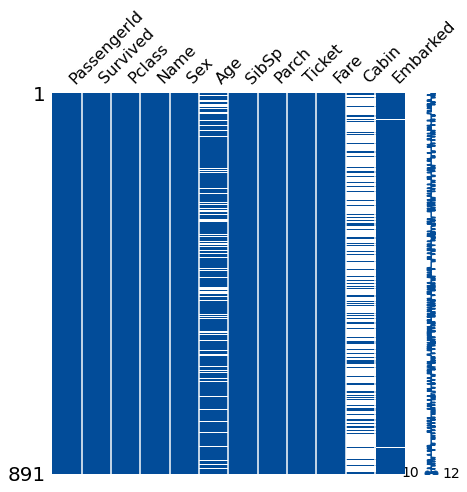

In [7]:
msno.matrix(df=df_train.iloc[:, :], figsize=(7,7), color=(0.01,0.3,0.6))

<AxesSubplot:>

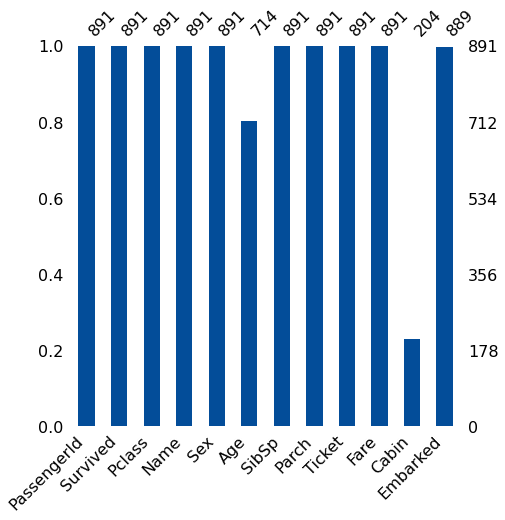

In [8]:
msno.bar(df=df_train.iloc[:, :], figsize=(7,7), color=(0.01,0.3,0.6) )

**1.2 Target label 확인**
- Target label이 어떤 distribution을 가지고 있는지 확인
- 지금과 같은 binary classification 문제의 경우, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있음

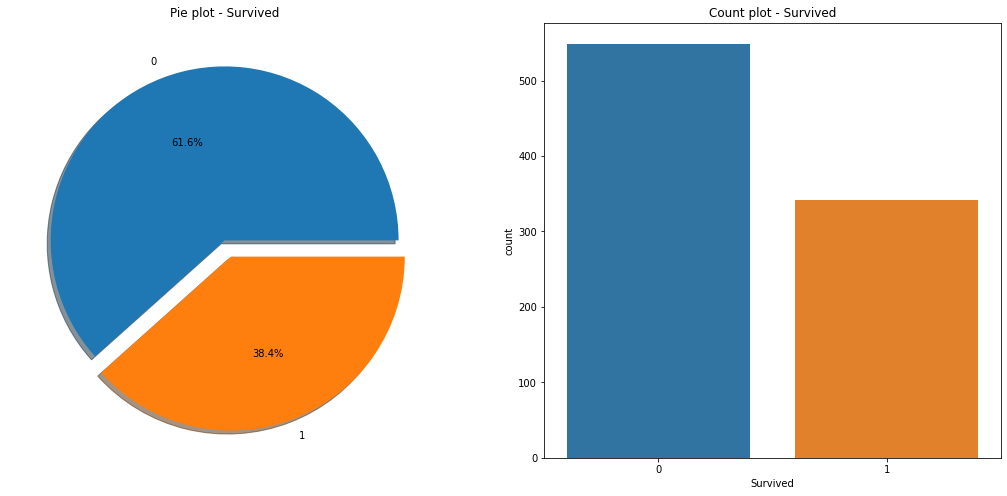

In [9]:
f, ax = plt.subplots(1,2,figsize=(18,8))

df_train['Survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()


# **2. Exploratory data analysis**
- 시각화 라이브러리는 matplotlib, seaborn, plotly 등을 목적에 맞게 사용하여 참고한다

**2.1 Pclass**
- Pclass는 카테고리이면서, 순서가 있는 데이터 타입이다
- Pclass에 따른 생존률을 살펴보기 위해, pandas dataframe의 groupby를 사용한다
- 'Pclass'와 'Survived'를 pclass로 묶는다. 각 pclass마다 0,1이 카운트 되는데, 이를 평균 내어 각 pclass별 생존률을 확인한다.

In [10]:
df_train[['Pclass','Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [11]:
df_train[['Pclass','Survived']].groupby(['Pclass'],as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


pandas의 crosstab을 사용하면 위의 결과를 조금 더 쉽게 볼 수 있다

In [12]:
pd.crosstab(df_train['Pclass'],df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


그룹화된 객체의 클래스별 생존률을 확인한다

<AxesSubplot:xlabel='Pclass'>

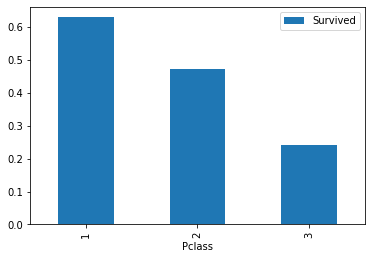

In [13]:
df_train[['Pclass','Survived']].groupby(['Pclass'],as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

더 좋은 클래스에 탄 승객이 생존할 확률이 더 높다.

seaborn의 countplot을 이용하여 특정 label에 따른 개수를 확인할 수 있다.

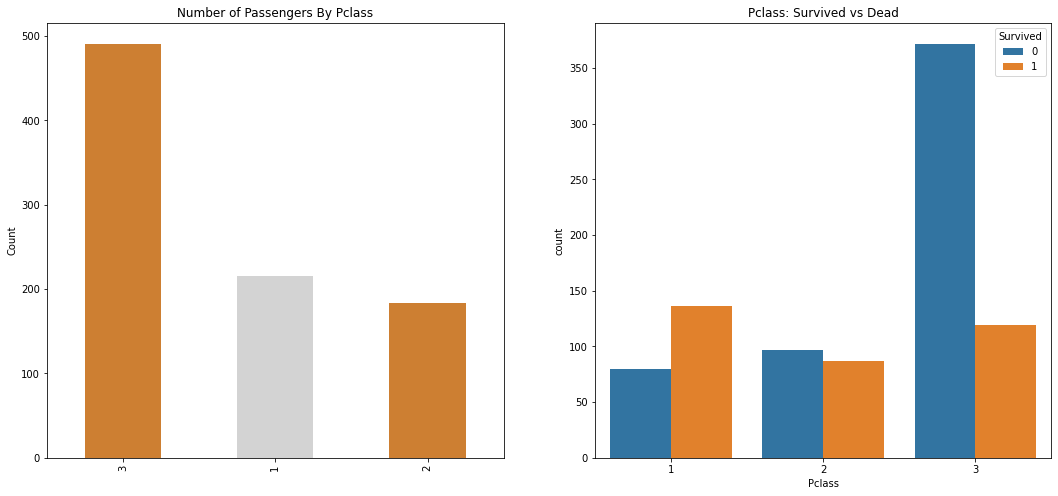

In [14]:
y_position = 1.0
f, ax = plt.subplots(1,2,figsize=(18,8))
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass',y=y_position)
ax[0].set_ylabel('Count')
sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

생존에 Pclass가 영향을 미친다는 것은 꽤나 합당하다고 볼 수 있다. 따라서 후에 모델을 세울 때 Pclass feature를 사용하는 것이 바람직하다

**2.2 Sex**
- 성별에 따른 생존률 확인
- 마찬가지로 pandas groupby와 seaborn countplot을 사용하여 시각화한다.

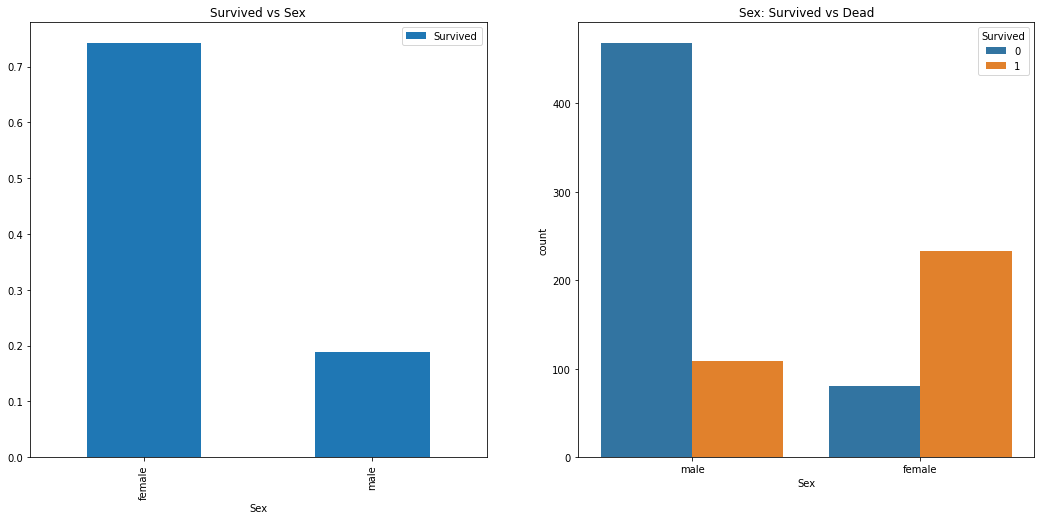

In [15]:
f, ax = plt.subplots(1,2,figsize=(18,8))
df_train[['Sex','Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived',data=df_train,ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

In [16]:
df_train[['Sex','Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [17]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


- Pclass와 같이, 성별 또한 중요한 feature임을 확인할 수 있다

**2.3 Both Sex and Pclass**
- Sex와 Pclass 2개를 통합하여 생존률이 어떻게 달라지는지 확인
- seaborn의 factorplot을 이용하면, 3차원으로 이루어진 그래프를 그릴 수 있다

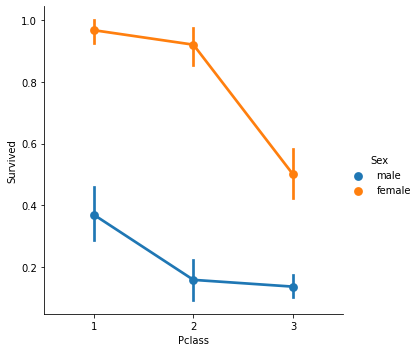

In [18]:
sns.factorplot('Pclass','Survived',hue='Sex',data=df_train)

- 모든 클래스에서 female이 생존할 확률이 확연하게 높다
- 또한 male, female 상관 없이, 클래스가 높을수록 생존할 확률이 높다
- hue 대신 column으로 확인해보면 아래와 같다

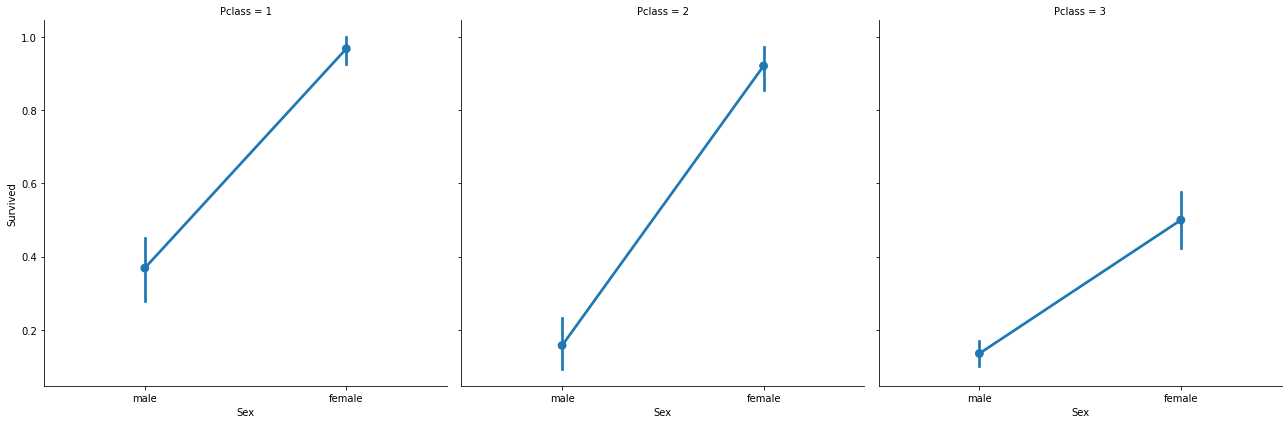

In [19]:
sns.factorplot(x='Sex',y='Survived',col='Pclass',data=df_train, satureation=.5,size=6,aspect=1)

**2.4 Age**

In [20]:
print('나이가 가장 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('나이가 적은 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))

나이가 가장 많은 탑승객 : 80.0 Years
나이가 적은 많은 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


- 나이에 따른 생존 histogram

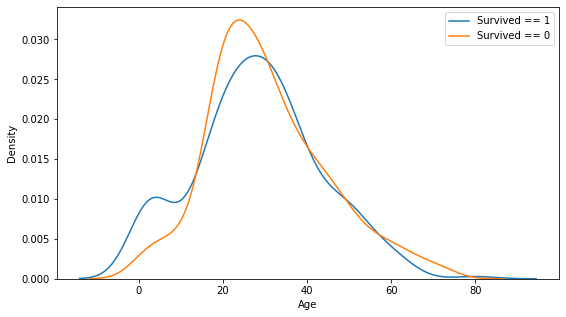

In [21]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'],ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'],ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

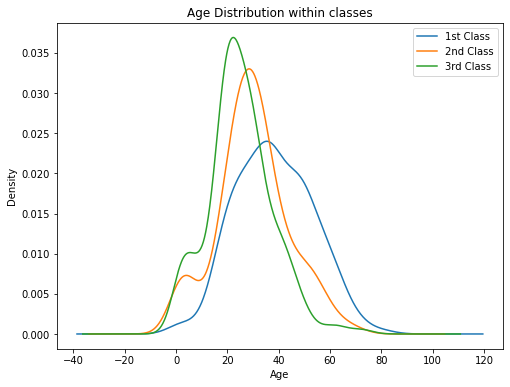

In [22]:
plt.figure(figsize=(8,6))
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

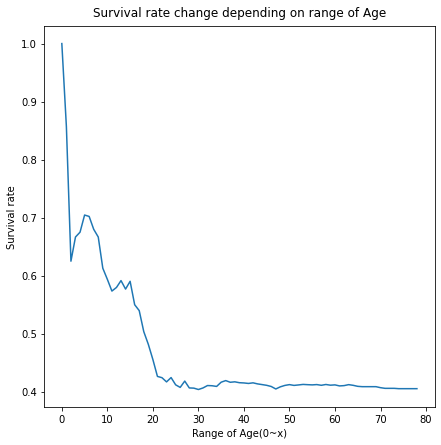

In [23]:
cummulate_survival_ratio = []
for i in range(1,80):
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived']))
plt.figure(figsize=(7,7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.01)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

- 나이가 어릴수록 생존 확률히 월등히 높다. 따라서 중요한 feature로 사용 가능

**2.5 Embarked**
- 탑승한 항구에 따른 생존률 확인

<AxesSubplot:xlabel='Embarked'>

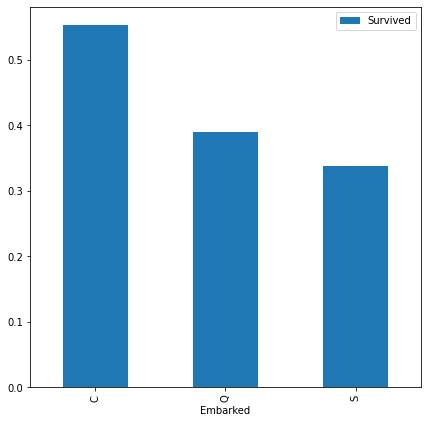

In [24]:
f, ax = plt.subplots(1,1,figsize=(7,7))
df_train[['Embarked','Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived',ascending=False).plot.bar(ax=ax)

- 조금의 차이는 있지만 생존률은 비슷
- 모델에 얼마나 큰 영향을 미칠지는 확인할 수 없지만, 일단 사용

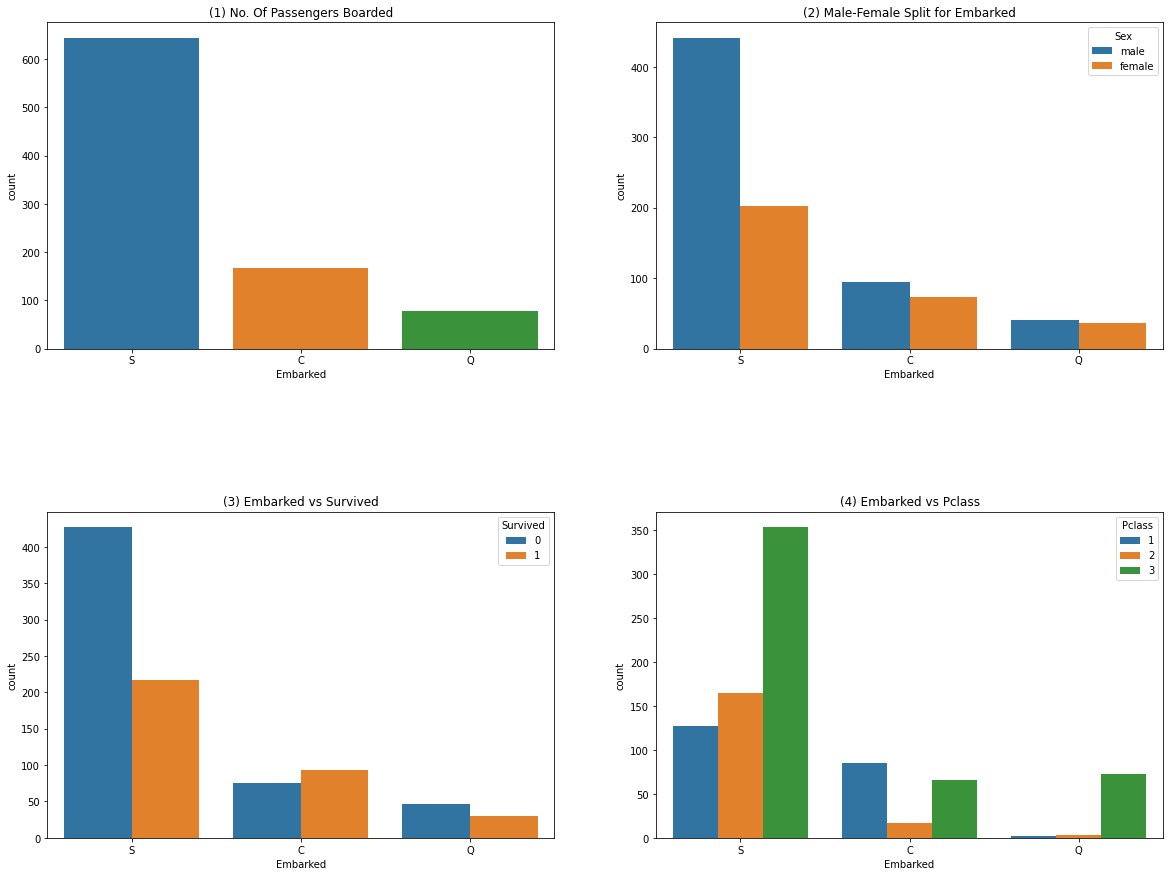

In [25]:
f, ax = plt.subplots(2,2,figsize=(20,15))

sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')

sns.countplot('Embarked', hue='Sex',data=df_train,ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')

sns.countplot('Embarked', hue='Survived',data=df_train,ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')

sns.countplot('Embarked', hue='Pclass',data=df_train,ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure1 : 전체적으로 S에서 가장 많은 승객이 탑승
- Figure2 : C와 Q는 남녀 비율이 비슷. S는 남자가 많음
- Figure3 : S의 경우 생존 확률이 낮다. 남자가 S에서 많이 탄 것과 연관 있을 수 있음
- Figure4 : Class 별로 split하여 확인한 결과 C에서 탑승한 승객의 생존률이 높은 것은, 클래스가 높기 때문

**2.7 Family - SibSp(형제 자매) + Parch(부모 자녀)**

In [26]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자기 자신을 포함하기 위한 +1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [27]:
print('Max size of Family: ',df_train['FamilySize'].max())
print('Min size of Family: ',df_train['FamilySize'].min())

Max size of Family:  11
Min size of Family:  1


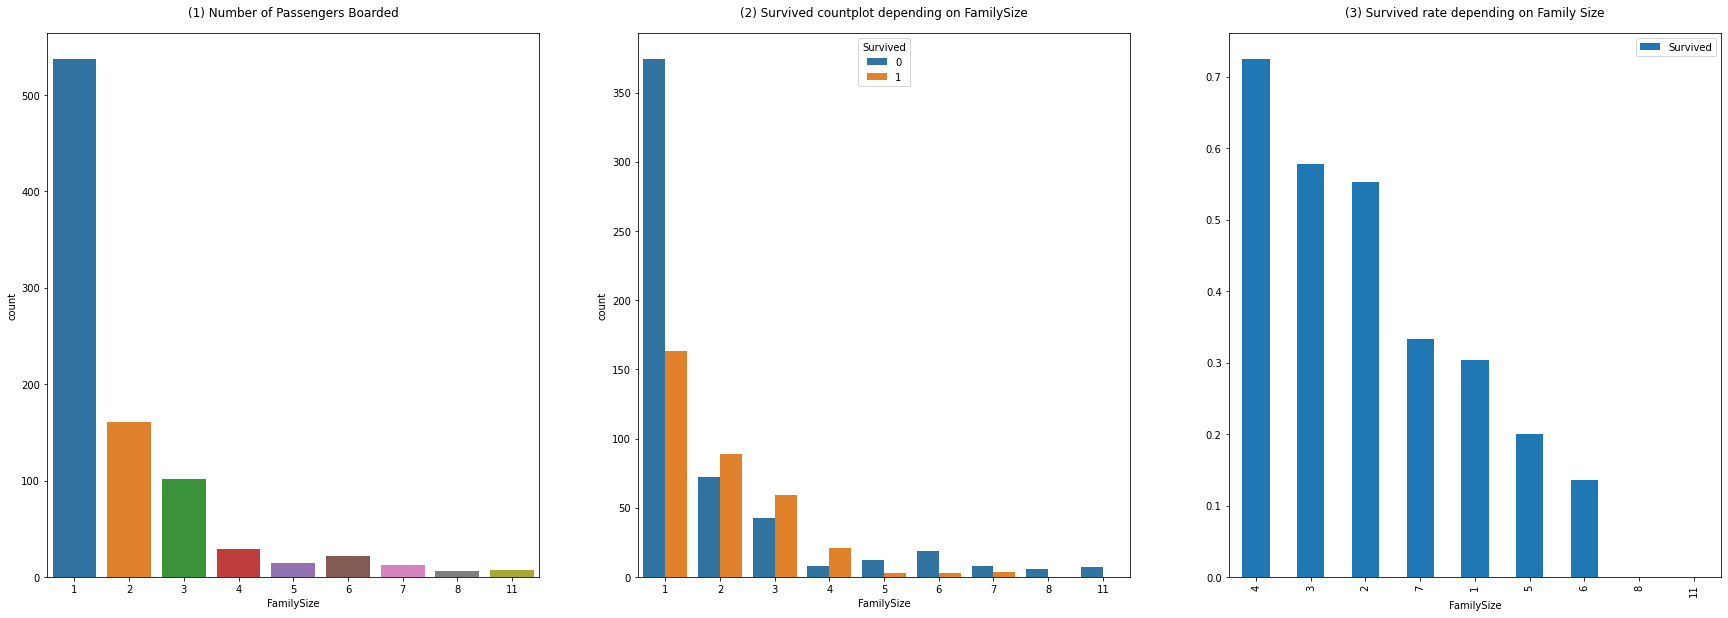

In [28]:
f, ax = plt.subplots(1,3,figsize=(30,10))

sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) Number of Passengers Boarded',y=1.02)

sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize',y=1.02)

df_train[['FamilySize','Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived',ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on Family Size', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- 가족이 4명인 경우 생존 확률이 가장 높음

**2.8 Fare**
- 탑승 요금에 따른 histogram

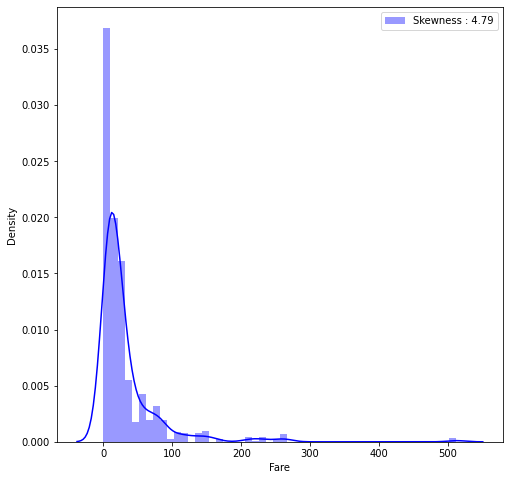

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()),ax=ax)
g=g.legend(loc='best')

- Distribution이 매우 비대칭(High skewness). 이 상태로 모델에 넣는다면 자칫 모델이 잘못 학습할 수 있음.
- outlier의 영향을 줄이기 위해 Fare에 log 취하기
- Fare column의 모든 데이터를 log 취하기 위해 lambda 함수를 이용하여 map에 인수로 넣어주면 데이터에 그대로 적용

In [30]:
df_test.loc[df_test.Fare.isnull(),'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

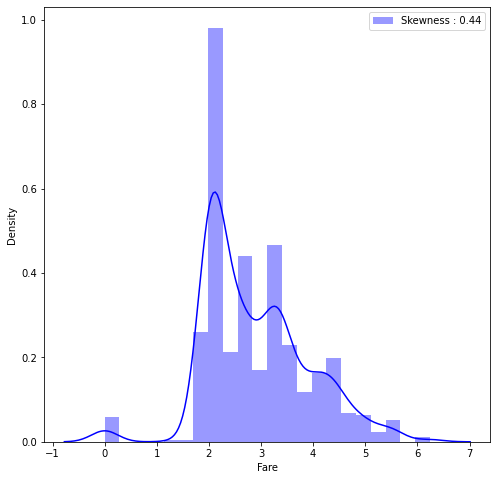

In [31]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()),ax=ax)
g=g.legend(loc='best')

- log를 취하면서 비대칭성이 많이 사라짐
- 위와 같이 모델의 성능을 높이기 위해 feature들에 조작을 가하거나, 새로운 feature를 추가하는 것을 feature engineering이라고 한다